# Testing the `intepret` module

**Authorship:**
Adam Klie, *10/05/2022*
***
**Description:**
Notebook for testing out the `intepret` module.

In [2]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np
import pandas as pd
import eugene as eu

Global seed set to 13
2022-10-06 18:27:37.059378: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Fontconfig warning: ignoring UTF-8: not a valid region tag


In [3]:
x = torch.randn(10, 4, 100)
x_rev = torch.randn(10, 4, 100)
y = torch.randn(10, 2)

In [4]:
sdata = eu.datasets.random1000()
eu.pp.ohe_seqs_sdata(sdata)
eu.pp.reverse_complement_seqs_sdata(sdata)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added
SeqData object modified:
	ohe_rev_seqs: None -> 1000 ohe_rev_seqs added


In [5]:
model = eu.models.DeepBind(input_len=100, output_dim=2)

# Feature attribution

In [6]:
def check_attribution_method(model, sdata, method, **kwargs):
    """
    Check that an attribution method works
    """
    explains = eu.interpret.nn_explain(
        model=model, 
        inputs=(x, x_rev), 
        target=0, 
        saliency_type=method,
        **kwargs
    )
    assert explains.shape == (10, 4, 100)
    eu.interpret.feature_attribution_sdata(
        sdata=sdata,
        model=model,
        target=0,
        method=method,
        **kwargs
    )
    assert sdata.uns[f"{method}_imps"].shape == (1000, 4, 100)

In [7]:
def test_NaiveISM():
    check_attribution_method(model, sdata, "NaiveISM")
test_NaiveISM()

HERE
No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

HERE
HERE
HERE
HERE
HERE
HERE
HERE
HERE


In [8]:
def test_InputXGradient():
    check_attribution_method(model, sdata, "InputXGradient")
test_InputXGradient()

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

In [9]:
def test_DeepLIFT():
    check_attribution_method(model, sdata, "DeepLift", reference="zero")
    check_attribution_method(model, sdata, "DeepLift", reference="shuffle")
    check_attribution_method(model, sdata, "DeepLift", reference="gc")
test_DeepLIFT()

/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=85, stride=85, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/Users/adamklie/miniconda3/envs/eugene/lib/python3.7/site-packages/torch/nn/functional.py:651: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note that order of the arguments: ceil_m

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
def test_GradientSHAP():
    check_attribution_method(model, sdata, "GradientSHAP", reference="zero")
    check_attribution_method(model, sdata, "GradientSHAP", reference="shuffle")
    check_attribution_method(model, sdata, "GradientSHAP", reference="gc")
test_GradientSHAP()

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

# Dim reduction

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

Make sure your matrix is sample by feature


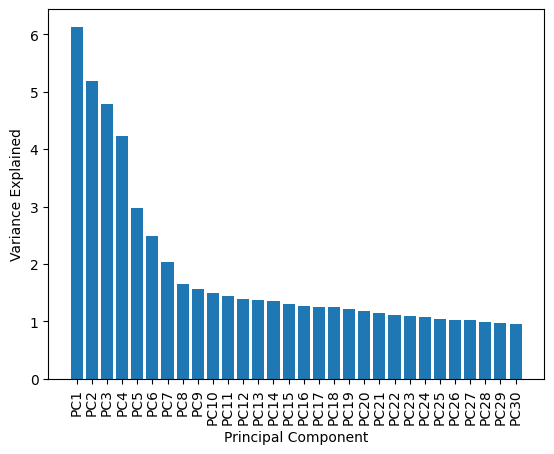

In [11]:
def test_pca(model, sdata):
    """
    Test PCA
    """
    from sklearn.decomposition import PCA
    eu.interpret.feature_attribution_sdata(
        sdata=sdata,
        model=model,
        target=0,
        method="InputXGradient"
    )
    eu.interpret.pca(sdata, uns_key="InputXGradient_imps")
    assert sdata.seqsm["InputXGradient_imps_pca"].shape == (1000, 30)
    assert isinstance(sdata.uns["InputXGradient_imps_pca"], PCA)
    eu.pl.skree(sdata, uns_key="InputXGradient_imps_pca")
test_pca(model, sdata)

In [12]:
def test_aggregate_importances_sdata(model, sdata):
    """
    Test PCA
    """
    from sklearn.decomposition import PCA
    eu.interpret.feature_attribution_sdata(
        sdata=sdata,
        model=model,
        target=0,
        method="InputXGradient"
    )
    eu.dataload.motif.jaspar_annots_sdata(sdata, motif_names=["GATA1"])
    eu.interpret.aggregate_importances_sdata(sdata, uns_key="InputXGradient_imps")
    assert "InputXGradient_imps_agg_scores" in sdata.pos_annot.df.columns
test_aggregate_importances_sdata(model, sdata)

No transforms given, assuming just need to tensorize.


Computing saliency on batches of size 128:   0%|          | 0/7 [00:00<?, ?it/s]

Saved PWM File as : motifs.meme


# Filter Visualization

In [13]:
from torch.utils.data import DataLoader

In [14]:
sdata = eu.datasets.random1000()
eu.pp.ohe_seqs_sdata(sdata)
eu.pp.reverse_complement_seqs_sdata(sdata)
sdataset = sdata.to_dataset(target_keys="activity_0")
sdataloader = DataLoader(sdataset, batch_size=32, num_workers=0)

One-hot encoding sequences:   0%|          | 0/1000 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 1000 ohe_seqs added
SeqData object modified:
	ohe_rev_seqs: None -> 1000 ohe_rev_seqs added
No transforms given, assuming just need to tensorize.


In [15]:
from eugene.interpret._filter_viz import _get_first_conv_layer, _get_activations_from_layer, _get_filter_activators, _get_pfms

In [16]:
def test_get_first_conv_layer(model):
    first_layer = _get_first_conv_layer(model)
    assert isinstance(first_layer, torch.nn.Conv1d)
test_get_first_conv_layer(model)

In [17]:
def test_get_activations_from_layer(model, sdataloader):
    first_layer = _get_first_conv_layer(model)
    np_activators, np_sequences = _get_activations_from_layer(first_layer, sdataloader, vocab="DNA")
    assert np_activators.shape == (1000, 16, 85)
    assert len(np_sequences) == 1000
    isinstance(np_sequences[0], str)
test_get_activations_from_layer(model, sdataloader)

Getting maximial activating seqlets:   0%|          | 0/31 [00:00<?, ?it/s]

In [18]:
def test_get_filter_activators(model, sdataloader):
    first_layer = _get_first_conv_layer(model)
    np_activators, np_sequences = _get_activations_from_layer(first_layer, sdataloader, vocab="DNA")
    activator_seqs = _get_filter_activators(np_activators, np_sequences, first_layer.kernel_size[0], method="Alipanahi15", threshold=0.75)
    assert len(activator_seqs) == 16
    assert isinstance(activator_seqs[0], list)
    assert isinstance(activator_seqs[0][0], str)
    activator_seqs = _get_filter_activators(np_activators, np_sequences, first_layer.kernel_size[0], method="Minnoye20", num_seqlets=10)
    assert len(activator_seqs) == 16
    assert isinstance(activator_seqs[0], list)
    assert isinstance(activator_seqs[0][0], str)
    assert len(activator_seqs[0]) == 10
test_get_filter_activators(model, sdataloader)

Getting maximial activating seqlets:   0%|          | 0/31 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

In [19]:
def test_get_pfm(model, sdataloader):
    first_layer = _get_first_conv_layer(model)
    np_activators, np_sequences = _get_activations_from_layer(first_layer, sdataloader, vocab="DNA")
    activator_seqs = _get_filter_activators(np_activators, np_sequences, first_layer.kernel_size[0], method="Alipanahi15", threshold=0.75)
    pfms = _get_pfms(activator_seqs, first_layer.kernel_size[0], vocab="DNA")
    assert len(pfms) == 16
    assert isinstance(pfms[0], pd.DataFrame)
    assert pfms[0].shape == (16, 4)
test_get_pfm(model, sdataloader)

Getting maximial activating seqlets:   0%|          | 0/31 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
def test_generate_pfms_sdata(model, sdata):
    eu.interpret.generate_pfms_sdata(model, sdata)
    assert "pfms" in sdata.uns
    assert len(sdata.uns["pfms"]) == 16
    assert isinstance(sdata.uns["pfms"][0], pd.DataFrame)
    assert sdata.uns["pfms"][0].shape == (16, 4)
test_generate_pfms_sdata(model, sdata)

No transforms given, assuming just need to tensorize.


Getting maximial activating seqlets:   0%|          | 0/7 [00:00<?, ?it/s]

Getting filter activators for 16 filters:   0%|          | 0/16 [00:00<?, ?it/s]

Getting PFMs from filters:   0%|          | 0/16 [00:00<?, ?it/s]

# *In Silico* Experimentation

## *In Silico* Evolution

In [21]:
model = eu.models.DeepBind(input_len=100, output_dim=1)

In [22]:
# Set-up of some sequences to test
seq_num = np.random.choice(32, size=1, replace=False).squeeze()
seqs = sdata.seqs[:32]
seq = seqs[seq_num]
ohe_seqs = sdata.ohe_seqs[:32]
ohe_seq = ohe_seqs[seq_num]
seq, ohe_seq.shape, ohe_seqs.shape

('CACGAGTGGGATCATCTCCAACTGAGGTCTTGCAGAATATCAAATAGGAAGCCCAAGGAGGGAAATAATTGCTTAATCCCCAATTGAGAGTAACGCATAT',
 (4, 100),
 (32, 4, 100))

### Test `in_silico_best_k_muts`

In [23]:
mut_ohe_seq, delta, delta_ind = eu.interpret.best_k_muts(model, ohe_seq, k=1)
mut_seq = eu.pp.decode_seq(mut_ohe_seq.squeeze(axis=0))
seq[delta_ind.squeeze()], mut_seq[delta_ind.squeeze()], seq, mut_seq, eu.pp._utils._hamming_distance(seq, mut_seq)

('A',
 'C',
 'CACGAGTGGGATCATCTCCAACTGAGGTCTTGCAGAATATCAAATAGGAAGCCCAAGGAGGGAAATAATTGCTTAATCCCCAATTGAGAGTAACGCATAT',
 'CACGAGTGGGATCATCTCCAACTGAGGTCTTGCAGAATCTCAAATAGGAAGCCCAAGGAGGGAAATAATTGCTTAATCCCCAATTGAGAGTAACGCATAT',
 1)

In [24]:
def test_in_silico_best_k_muts():
    mut_ohe_seq, delta, delta_ind = eu.interpret.best_k_muts(model, ohe_seq, k=1)
    mut_seq = eu.pp.decode_seq(mut_ohe_seq.squeeze(axis=0))
    assert eu.pp._utils._hamming_distance(seq, mut_seq) == 1
test_in_silico_best_k_muts()

### Test `in_silico_best_mut_seqs`

In [25]:
def test_in_silico_best_mut_seqs():
    mut_ohe_seqs, deltas, delta_inds = eu.interpret.best_mut_seqs(model, ohe_seqs, batch_size=32)
    for i in range(len(mut_ohe_seqs)):
        mut_seq = eu.pp.decode_seq(mut_ohe_seqs[i])
        assert eu.pp._utils._hamming_distance(seqs[i], mut_seq) == 1
test_in_silico_best_mut_seqs()

### Test `in_silico_evolution`

In [26]:
def test_evolution():
    evolved_ohe_seq, deltas, delta_pos = eu.interpret.evolution(
        model, 
        ohe_seq, 
        force_different=True
    )
    evolved_seq = eu.pp.decode_seq(evolved_ohe_seq)
    assert eu.pp._utils._hamming_distance(seq, evolved_seq) == 10
test_evolution()

In [27]:
sdata_subset = sdata[:5]

In [28]:
def test_evolve_seqs_sdata(model, sdata):
    evolved_seqs = eu.interpret.evolve_seqs_sdata(
        model,
        sdata,
        rounds=5,
        force_different=True,
        return_seqs=True
    )
    assert "original_score" in sdata.seqs_annot
    assert "evolved_5_score" in sdata.seqs_annot
    assert len(evolved_seqs) == 5
test_evolve_seqs_sdata(model, sdata_subset)

Evolving seqs:   0%|          | 0/5 [00:00<?, ?it/s]

True
SeqData object modified:
    seqs_annot:
        + evolved_5_score, evolved_3_score, evolved_2_score, evolved_4_score, evolved_1_score, original_score


TypeError: object of type 'NoneType' has no len()

### Feature implantation

In [31]:
# Prep data
model = eu.models.DeepBind(input_len=66, output_dim=1)
seq = sdata.seqs[0]
ohe_seq = eu.pp.ohe_seq(seq)
meme = eu.dl.motif.MinimalMEME(path="../../_data/CPEs.meme")
motif = meme.motifs["TATA"]
name = motif.name
pfm = motif.pfm
consensus = motif.consensus
pos = 2

In [32]:
implanted_seq = eu.pp.feature_implant_seq(seq, consensus, pos, encoding="str")

'TGCCCCTATAAATACCCCGAGTTCTAAGGATGCGAATAACACAAAAAGCCGCGATCTTAAACGTTCTACACTTCTAAGGTCTGCATGAGCGAACCGAAAC'

In [34]:
len(consensus)

16

In [35]:
implanted_seqs = eu.pp.feature_implant_across_seq(seq, consensus, encoding="str")

In [36]:
len(implanted_seqs)

85

In [58]:
implanted_seq = eu.pp.feature_implant_seq(ohe_seq, pfm, pos, encoding="onehot")

In [63]:
implanted_seq.transpose()[2:18] == pfm

array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]])

In [54]:
implanted_seqs = eu.pp.feature_implant_across_seq(ohe_seq, pfm, encoding="onehot")

In [56]:
pfm

array([[0.1275, 0.3765, 0.1195, 0.3765],
       [0.1575, 0.3985, 0.199 , 0.2455],
       [0.249 , 0.303 , 0.197 , 0.251 ],
       [0.1235, 0.655 , 0.0755, 0.1455],
       [0.01  , 0.002 , 0.002 , 0.986 ],
       [0.968 , 0.    , 0.    , 0.032 ],
       [0.002 , 0.014 , 0.006 , 0.978 ],
       [0.992 , 0.    , 0.002 , 0.006 ],
       [0.653 , 0.012 , 0.002 , 0.333 ],
       [0.974 , 0.    , 0.008 , 0.018 ],
       [0.341 , 0.028 , 0.036 , 0.5955],
       [0.6955, 0.0815, 0.1195, 0.1035],
       [0.1255, 0.432 , 0.3165, 0.1255],
       [0.291 , 0.418 , 0.175 , 0.1155],
       [0.263 , 0.3445, 0.1755, 0.2175],
       [0.307 , 0.3085, 0.2365, 0.1475]])

In [57]:
implanted_seqs[0][0:16].transpose() == pfm

array([[0.1275, 0.3765, 0.1195, 0.3765],
       [0.1575, 0.3985, 0.199 , 0.2455],
       [0.249 , 0.303 , 0.197 , 0.251 ],
       [0.1235, 0.655 , 0.0755, 0.1455],
       [0.01  , 0.002 , 0.002 , 0.986 ],
       [0.968 , 0.    , 0.    , 0.032 ],
       [0.002 , 0.014 , 0.006 , 0.978 ],
       [0.992 , 0.    , 0.002 , 0.006 ],
       [0.653 , 0.012 , 0.002 , 0.333 ],
       [0.974 , 0.    , 0.008 , 0.018 ],
       [0.341 , 0.028 , 0.036 , 0.5955],
       [0.6955, 0.0815, 0.1195, 0.1035],
       [0.1255, 0.432 , 0.3165, 0.1255],
       [0.291 , 0.418 , 0.175 , 0.1155],
       [0.263 , 0.3445, 0.1755, 0.2175],
       [0.307 , 0.3085, 0.2365, 0.1475],
       [1.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.    , 0.    , 1.    , 0.    ],
       [1.    , 0.    , 0.    , 0.    ],
       [0.    , 0.    , 1.    , 0.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.    , 0.    , 0.    , 1.    ],
       [0.    , 1.    , 0.    , 0.    ],
       [0.    , 

In [39]:
implanted_seqs = eu.pp.feature_implant_across_seq(ohe_seq, pfm, encoding="onehot", onehot=True)

True

In [46]:
len(eu.interpret.feature_implant_seq_sdata(
    model, 
    sdata_subset, 
    seq_id=sdata_subset.names[0], 
    feature=consensus, 
    feature_name=name, 
    encoding="str", 
    onehot=False, 
    device="cpu", 
    store=False
))

85

In [51]:
eu.interpret.feature_implant_seqs_sdata(
    model,
    sdata_subset,
    feature=consensus,
    seqsm_key=f"{name}_slide",
    encoding="str",
    onehot=False,
    device="cpu"
)

Implanting feature in all seqs of sdata:   0%|          | 0/5 [00:00<?, ?it/s]

In [52]:
sdata.seqsm["TATA_slide"].shape

(5, 85)

---